# Test Binning

## Load Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import time
from itertools import repeat
import multiprocessing
from joblib import Parallel, delayed

In [3]:
problem_regions = set([
    "chr8_25402079-25402692.npy",
    "chr8_25400686-25401414.npy",
    "chr18_14614837-14615417.npy",
    "chr4_135051533-135052045.npy",
    "chr15_27348617-27349198.npy",
    "chr7_1142401-1144866.npy",
    "chr7_151782043-151782443.npy",
    "chr12_8402962-8403388.npy",
    "chr1_37640513-37642567.npy",
    "chr16_84401461-84401863.npy",
    "chr20_34665376-34666969.npy"
])

NUM_HASHES = 1000

class signatureMtxs():
    def __init__(self):
        self.signature_mtxs = []

    """
    Load into memory all signature matrices
    """
    def load(self, directory, local_problem_regions = problem_regions):
        for file in os.listdir(directory):
            if file in local_problem_regions: continue
            self.signature_mtxs.append(
                np.load( os.path.join(directory,file) )
            )

    def loadMatrix(self, path):
        self.signature_mtxs.append(np.load(path))

    """
    Use banding technique to bin reads by similarity
    """
    def band(self, band_length):
        counts = [0 for _ in range(4)]
        for matrix in self.signature_mtxs:
            labels = matrix[0,:].astype('int8')
            signature_matrix = matrix[1:,:]
            for i, count in enumerate(
                self.tprSignatureMatrix(signature_matrix, band_length, labels)
            ):
                counts[i] += count
        return counts

    """
    Generate TPR and FPR for a given signature matrix, band length, and label list
    Returns [test_pos, tot_pos, test_neg, tot_neg]
    """
    def tprSignatureMatrix(self, signature_matrix, band_length, labels, wantAdjacencyMatrix = False):
        def connectBucket(bucket, adjacencyMatrix):
            for i in range(len(bucket)-1):
                for j in range(i+1, len(bucket)):
                    adjacencyMatrix[bucket[i],bucket[j]] = True
                    adjacencyMatrix[bucket[j],bucket[i]] = True
            return adjacencyMatrix

        firstOcc = np.argmax(labels>1)
        adjacencyMatrix = np.zeros((len(labels), len(labels)))

        for i in range(signature_matrix.shape[0]//band_length):
            buckets = defaultdict(list[int])
            startBucket = i*band_length
            endBucket = (i+1)*band_length
            for j in range(signature_matrix.shape[1]):
                buckets[signature_matrix[startBucket:endBucket, j].tobytes()].append(j)
            for bucket in buckets.values():
                adjacencyMatrix = connectBucket(bucket, adjacencyMatrix)

        if wantAdjacencyMatrix:
            return self.tpr_fpr(len(labels), firstOcc, adjacencyMatrix), adjacencyMatrix

        return self.tpr_fpr(len(labels), firstOcc, adjacencyMatrix)

    def tpr_fpr(self, n, firstOcc, adjacencyMatrix):
        trueMask = np.zeros((n , n), dtype = bool)
        trueMask[:firstOcc, :firstOcc] = 1
        trueMask[firstOcc:, firstOcc:] = 1

        true_pos = int(np.sum(adjacencyMatrix, where = trueMask)/2)
        tot_pos = int((np.sum(trueMask) - n)/2)
        false_pos = int(np.sum(adjacencyMatrix, where = ~trueMask)/2)
        tot_neg = int(np.sum(~trueMask)/2)

        return true_pos, tot_pos, false_pos, tot_neg

def loadFilter(path):
    if path == "euclidean":
        filter_dir = "/data/wford/sv_merge/output/signatureMtxs/euclidean/1000,20,5,1"
    elif path == "sketch":
        filter_dir = "/data/wford/sv_merge/output/signatureMtxs/sketch/1000,20,40"
    elif path == "minHash":
        filter_dir = "/data/wford/sv_merge/output/signatureMtxs/minHash/1000,20,40"
    else:
        filter_dir = path

    filter_test = signatureMtxs()
    start_time = time.time()
    filter_test.load(filter_dir)
    load_time = time.time()
    return filter_test, load_time - start_time

def bandFunction(filter_test, band_size):
    output = filter_test.band(band_size)
    return output

def bandTest(filter_test, band_sizes = range(1,200)):
    inputs = zip(repeat(filter_test), band_sizes)
    num_cores = multiprocessing.cpu_count()

    start = time.time()
    outputs = Parallel(n_jobs=num_cores, verbose=1)(delayed(bandFunction)(i, j) for i, j  in inputs)
    end = time.time()
    print("Compute Time:\t", end-start)
    
    tprs = []
    fprs = []
    for a, b, c, d in outputs:
        tprs.append(a/b)
        fprs.append(c/d)
    return outputs, band_sizes, tprs, fprs

def filterBandTests(path):
    print(path)
    filter_test, load_time = loadFilter(path)
    print("Load Time:\t", round(load_time, 2))

    outputs, band_sizes, tprs, fprs = bandTest(filter_test)

    return outputs, band_sizes, tprs, fprs

## Run Filters

In [3]:
euclidean_outputs, euclidean_bands, euclidean_tprs, euclidean_fprs = filterBandTests("euclidean")
sketch_outputs, sketch_bands, sketch_tprs, sketch_fprs = filterBandTests("sketch")

euclidean
Load Time:	 9.07


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   1 tasks      | elapsed:  2.7min
/home/wford/miniconda3/envs/workspace/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=128)]: Done 144 out of 199 | elapsed: 12.2min remaining:  4.7min
[Parallel(n_jobs=128)]: Done 199 out of 199 | elapsed: 17.6min finished


Compute Time:	 1056.045024394989
sketch
Load Time:	 6.04


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=128)]: Done 144 out of 199 | elapsed:  7.0min remaining:  2.7min


Compute Time:	 580.9352679252625


[Parallel(n_jobs=128)]: Done 199 out of 199 | elapsed:  9.7min finished


In [4]:
minHash_outputs, minHash_bands, minHash_tprs, minHash_fprs = filterBandTests("minHash")

minHash
Load Time:	 2.15


[Parallel(n_jobs=128)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=128)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=128)]: Done 144 out of 199 | elapsed:  6.7min remaining:  2.5min


Compute Time:	 548.4828109741211


[Parallel(n_jobs=128)]: Done 199 out of 199 | elapsed:  9.1min finished


## Plot ROC Curve

In [5]:
"""
Plot the ROC curve
"""
def plotROC(tprs, fprs, bands = False, title = "ROC Curve", outputs = False):
    if outputs:
        tprs = []
        fprs = []
        for a, b, c, d in outputs:
            tprs.append(a/b)
            fprs.append(c/d)

    # Plot the ROC curve
    fig, ax = plt.subplots()
    if bands:
        plt.scatter(fprs, tprs, c = bands, marker = ".")
        num_labels = min(10, len(bands))
        scale = int(len(bands)//num_labels)
        for i in range(num_labels):
            index = i*scale
            ax.text(fprs[index], tprs[index]+0.05, bands[index])
    else:
        plt.scatter(fprs, tprs, marker = ".")
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc = "lower right")

    plt.show()

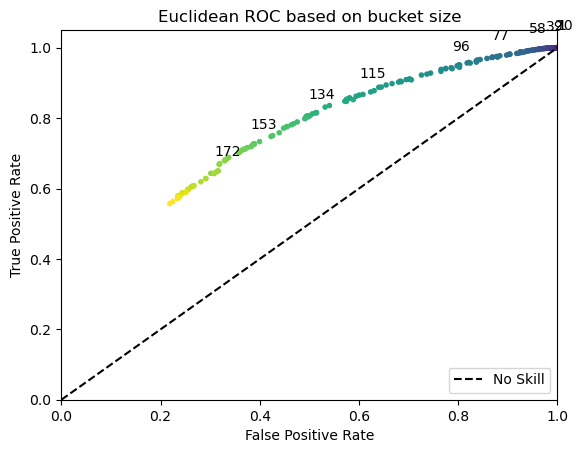

In [88]:
title = "Euclidean ROC based on bucket size"
plotROC(euclidean_tprs, euclidean_fprs, euclidean_bands, title)

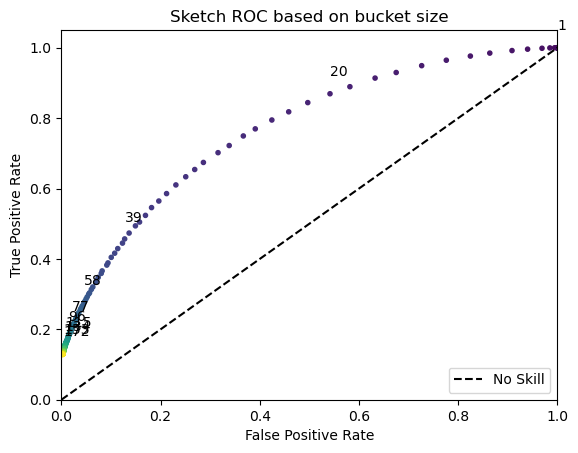

In [89]:
title = "Sketch ROC based on bucket size"
plotROC(sketch_tprs, sketch_fprs, sketch_bands, title)

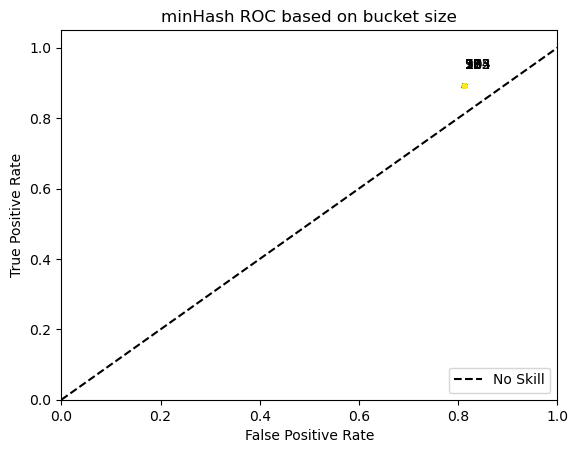

In [6]:
title = "minHash ROC based on bucket size"
plotROC(minHash_tprs, minHash_fprs, minHash_bands, title)

### Why is minHash all stacked in one place?


In [18]:
minHash_dir = "/data/wford/sv_merge/output/signatureMtxs/minHash/1000,20,40"
minHash_test = signatureMtxs()
test_matrices = []
for i in range(4):
    minHash_test.loadMatrix(os.path.join(minHash_dir, os.listdir(minHash_dir)[i]))
    test_matrices.append(minHash_test.signature_mtxs[i])

In [67]:
def show_problems(matrix):
    total_dif = 0
    n = matrix.shape[1]
    difs = [[0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            dif = sum(matrix[:,i] - matrix[:,j])
            if dif == 0 and not np.all(matrix[:,i] == matrix[:,j]):
                print("Weirdness reads:", i, j)
            difs[i][j] = dif
            total_dif += abs(dif)
    print(total_dif)

    vmin = np.min(difs)
    vmax = np.max(difs)
    print(vmin, vmax)
    plt.imshow(difs, cmap='viridis', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar()
    cbar.set_label('Value')
    plt.show()

52312.0
-1000.0 1000.0


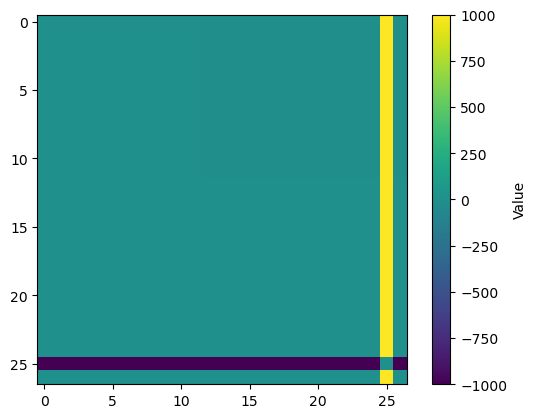

[1. 2. 2. ... 2. 2. 2.]
[2. 1. 1. ... 1. 1. 1.]


In [75]:
show_problems(test_matrices[0])
print(test_matrices[0][:,0])
print(test_matrices[0][:,25])

156.0
-1.0 1.0


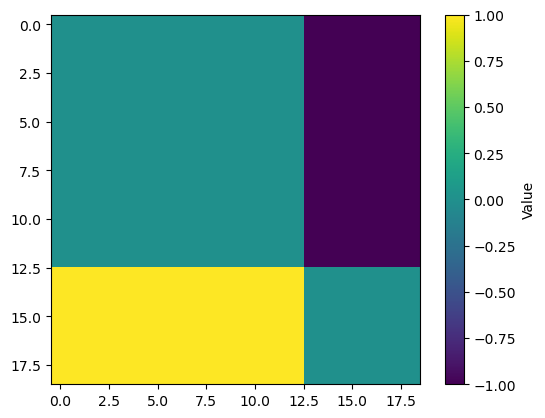

In [69]:
show_problems(test_matrices[1])

90.0
-1.0 1.0


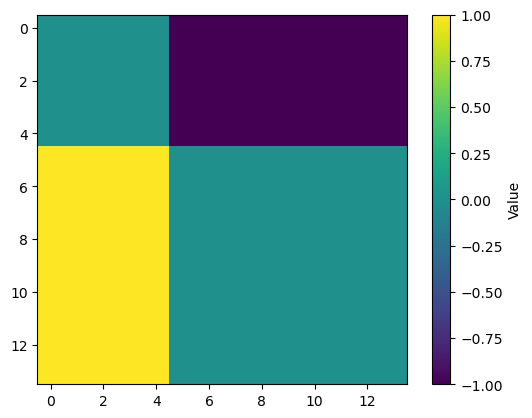

In [70]:
show_problems(test_matrices[2])

38150.0
-1001.0 1001.0


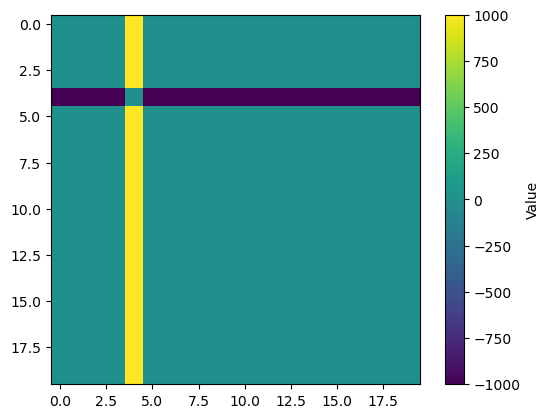

In [71]:
show_problems(test_matrices[3])

## Case Study Regions Analysis:

Repetitive Regions:
```
chr16	5484407	5484741
chr6	30332563	30332851
```

Non Repetitive:
```
chr16	14396657	14397075
chr6	23559543	23559857
```

`
samtools view -bh gs://fc-28761d6c-5677-4941-86e7-6e42b59a27f4/willard/HG002/HG002_haplotagged.bam\
      chr16:5484407-5484741 > repetitive.bam`

In [90]:
repetitive_paths = ["chr16_5484207-5484941.npy", "chr6_30332363-30333051.npy"]
non_repetitive_paths = ["chr16_14396457-14397275.npy", "chr6_23559343-23560057.npy"]

def getAdjacencyMatrix(path, matrix_path, bands = range(1,200, 40)):
    euclidean_path = "../../../output/signatureMtxs/euclidean/1000,20,5,1"
    sketch_path = "../../../output/signatureMtxs/sketch/1000,20,40"

    if path == "euclidean":
        path = euclidean_path
    elif path == "sketch":
        path = sketch_path

    filter_test = signatureMtxs()
    filter_test.loadMatrix(os.path.join(path, matrix_path))
    
    matrix = filter_test.signature_mtxs[-1]
    labels = matrix[0,:].astype('int8')
    signature_matrix = matrix[1:,:]

    outputs = []
    adjacency_matrices = []
    for i in bands:
        output, adjacency_matrix = filter_test.tprSignatureMatrix(signature_matrix, i, labels, wantAdjacencyMatrix=True)
        outputs.append(output)
        adjacency_matrices.append(adjacency_matrix)
    return outputs, adjacency_matrices

"""
def plotAdjacencyMatrices(adj_matrices, ):
    def plotAdjacencyMatrix(adjacencyMatrix):
        n = adjacencyMatrix.shape[0]
        plt.imshow(adjacencyMatrix, 
                   cmap = 'binary_r', 
                   interpolation='nearest', 
                   vmin=0, vmax=1
        )
        plt.title(f"Adjacency Matrix, ")
        plt.xticks(np.arange(n), np.arange(1, n + 1))
        plt.yticks(np.arange(n), np.arange(1, n + 1))

        plt.tick_params(axis='x', top=True, bottom=False, labeltop=True, labelbottom=False)
        plt.xlabel(f"White in pos i,j indicates i connects j")
        for x in self.firstOcc[1:]:
            plt.axhline(x - 0.5, color='red', linestyle='-', linewidth=2)
            plt.axvline(x - 0.5, color='red', linestyle='-', linewidth=2)
    
    for matrix in adj_matrices:
        plotAdjacencyMatrix(matrix, )
"""


### Euclidean

In [91]:
bands = list(range(1,200, 1))

#### Repetitive Regions

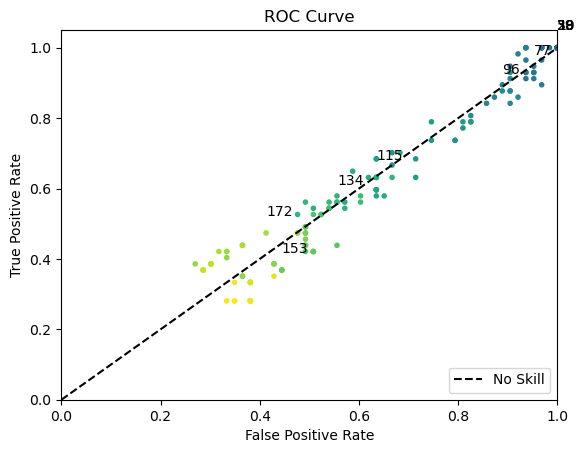

In [92]:
repetitive_outputs, repetitive_adjacenecy_matrices = getAdjacencyMatrix("euclidean", repetitive_paths[0], bands)
plotROC(0,0, bands=bands, outputs=repetitive_outputs)

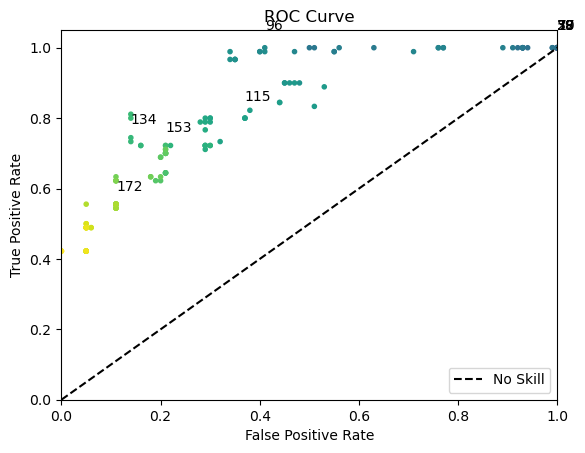

In [93]:
repetitive_outputs, repetitive_adjacenecy_matrices = getAdjacencyMatrix("euclidean", repetitive_paths[1], bands)
plotROC(0,0, bands=bands, outputs=repetitive_outputs)

#### Non-Repetitive Regions

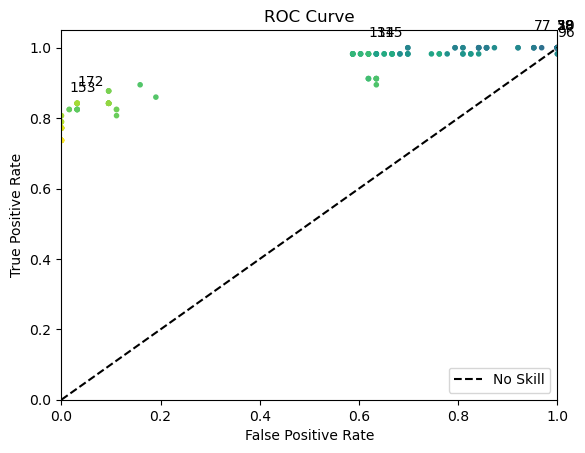

In [94]:
non_repetitive_outputs, non_repetitive_adjacenecy_matrices = getAdjacencyMatrix("euclidean", non_repetitive_paths[0], bands)
plotROC(0,0, bands= bands, outputs=non_repetitive_outputs)

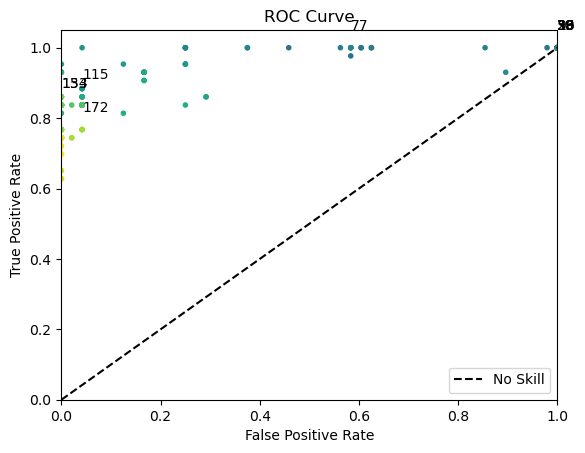

In [95]:
non_repetitive_outputs, non_repetitive_adjacenecy_matrices = getAdjacencyMatrix("euclidean", non_repetitive_paths[1], bands)
plotROC(0,0, bands= bands, outputs=non_repetitive_outputs)

### Sketch

#### Repetitive Regions

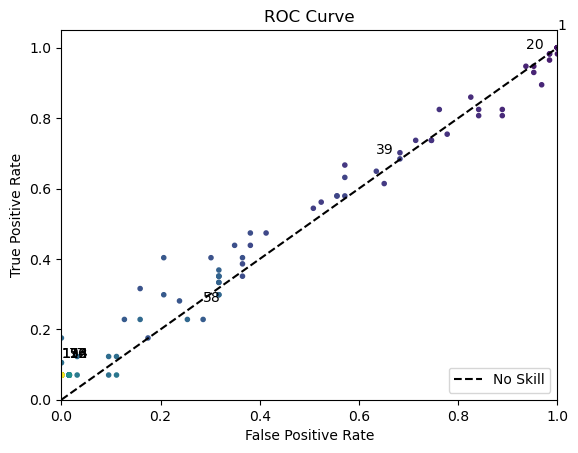

In [96]:
repetitive_outputs, repetitive_adjacenecy_matrices = getAdjacencyMatrix("sketch", repetitive_paths[0], bands)
plotROC(0,0, bands=bands, outputs=repetitive_outputs)

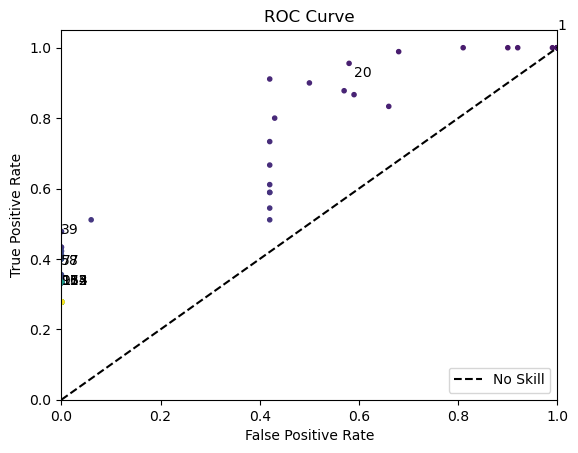

In [97]:
repetitive_outputs, repetitive_adjacenecy_matrices = getAdjacencyMatrix("sketch", repetitive_paths[1], bands)
plotROC(0,0, bands=bands, outputs=repetitive_outputs)

#### Non-Repetitive Regions

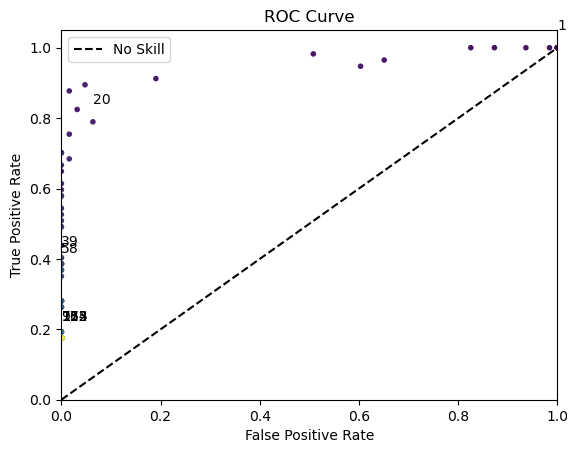

In [85]:
non_repetitive_outputs, non_repetitive_adjacenecy_matrices = getAdjacencyMatrix("sketch", non_repetitive_paths[0], bands)
plotROC(0,0, bands= bands, outputs=non_repetitive_outputs)

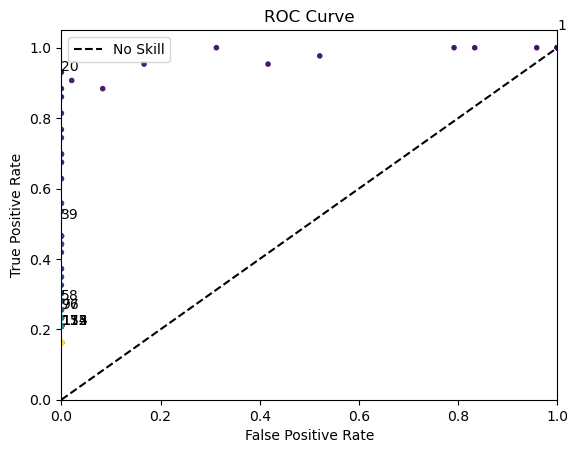

In [86]:
non_repetitive_outputs, non_repetitive_adjacenecy_matrices = getAdjacencyMatrix("sketch", non_repetitive_paths[1], bands)
plotROC(0,0, bands= bands, outputs=non_repetitive_outputs)